# Chapter 51: Regularization

### This code generates figures 1, 4, 5, and 6 in Chapter51: Regularization (vol. III)
#### Runs simulations for Example 5 in the chapter

TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.


<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs.  The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Saba Nasiri. 

required libraries:
    
1. numpy
2. matplotlib.pyplot
3. sign_vector (sign_vector.py is provided in the corresponding Github repository)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sign_vector import sign_vector

## Regularization boundary curves

Property (51.44) provides some intuition on how the choice of the penalty factor $q(w)$ defines the solution space. Figure 51.1 plots three contour curves in two-dimensional space corresponding to the level sets:

$$
\|w\|_1=1,\;\;\;\;\|w\|^2=1,\;\;\;\;\|w\|_1+\|w\|^2=1 \tag{51.45}
$$

It is seen from the figure that for $\ell_2-$ regularization, the search space for $w$ is limited to a region delineated by a circular boundary. In comparison, the search space for $\ell_1-$ regularization is delineated by a rotated square boundary with sharp edges, while the search space for elastic-net regularization is midway between these two options. All three regions are obviously convex.



In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

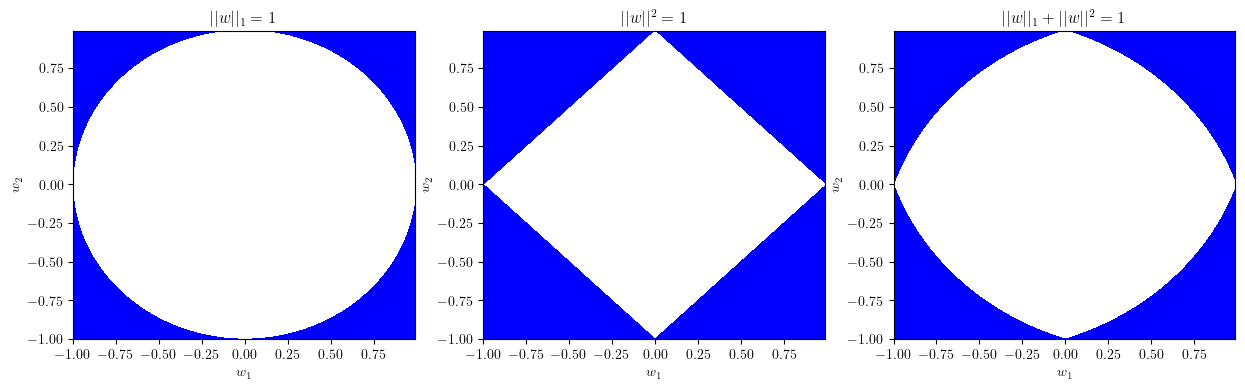

In [3]:
# figure 1
rr = 1 # ||w||^2 = 1
rr2 = 1
rre = 1

z1 = np.arange(-1, 1, 0.01)
z2 = np.arange(-1, 1, 0.01)
[X, Y] = np.meshgrid(z1, z2)  

f, axs =  plt.subplots(1, 3, figsize=(15,4))

c1 = X**2 + Y**2
axs[0].contourf(X, Y, c1, [1, 2], colors = ['blue'])
axs[0].set_title('$||w||_1 = 1$')
axs[0].set_xlabel('$w_1$')
axs[0].set_ylabel('$w_2$')

c2 = abs(X) + abs(Y)
axs[1].contourf(X, Y, c2, [1, 2], colors = ['blue'])
axs[1].set_title('$||w||^2 = 1$')
axs[1].set_xlabel('$w_1$')
axs[1].set_ylabel('$w_2$')

c3 = abs(X) + abs(Y) + X**2 + Y**2
axs[2].contourf(X, Y, c3, [2, 4], colors = ['blue'])
axs[2].set_title('$||w||_1 + ||w||^2 = 1$')
axs[2].set_xlabel('$w_1$')
axs[2].set_ylabel('$w_2$');

#plt.savefig('fig 51.1.pdf')

**Figure 51.1** The figure illustrates the boundary curves corresponding to conditions (51.45) in two-dimensional space. The search space for the parameter, $w$, is limited to the inside of the regions delineated by these curves. Observe that in all three cases, the search domain is convex.

## Example 51.5 (Comparing different regularized solutions)

In this example we compare numerically the behavior of $\ell_2-$, $\ell_1-$, and elastic-net regularization solutions. First, however, we need to show how to approximate the regularized solution to  (51.56a)--(51.56b).  We already know that we can employ a stochastic subgradient algorithm for this purpose to  arrive at good approximations for $w^{\star}_{reg}$. Under elastic-net regularization, the recursion would start from some random initial guess, denoted by $w_{-1}$, and then iterate as follows:

$$
w_n=(1-2\mu\rho)w_{n-1}-\mu\,\alpha\,\text{sign}(w_{n-1})+2\mu  y_n( x(n)- y_n^T w_{n-1}),\;\;n\geq 0 \tag{51.64}
$$

where $\mu$ is a small step-size parameter and the notation $w_n$ denotes the approximation for the regularized solution at iteration $n$. The sign function, when applied to a vector argument, returns a vector with entries equal to $\pm 1$ depending on the signs of the individual entries of $w_{n-1}$: +1 for nonnegative entries and $-1$ for negative entries. The algorithm is run ${multiple}$ times over the training data $\{x(n),y_n\}$, with the data being randomly reshuffled at the beginning of each epoch, namely: 

$(a)$ At the start of each epoch, the data $\{x(n), y_n\}$ is randomly reshuffled so that each epoch runs over the same dataset, albeit in a different random order.

$(b)$ The initial condition for the epoch of index $k$ is the iterate value that was obtained at the end of the previous epoch.

The iterate that is obtained at the end of the last epoch is the one that is taken to be the approximation for $w^{\star}_{reg}$.

Iteration (51.64) applies to both cases of $\ell_1-$regularization (by setting $\rho=0$) and elastic-net regularization when both $\alpha$ and $\rho$ are positive. Although we already have a closed-form solution for the $\ell_2-$regularized solution via expression (51.21), or can even arrive at it by means of the recursive least-squares (RLS) algorithm (50.123), the same stochastic recursion (51.64) can  be used to approximate the $\ell_2-$regularized solution as well by setting $\alpha=0$; the recursion leads to a computationally simpler algorithm than RLS, albeit at a slower convergence rate.


In [4]:
N = 4000 # number of data points
M = 20 # feature size
np.random.seed(0)

SR = np.random.rand(M, M) # random square-root of covariance matrix R=SR*SR'
H = np.random.randn(N, M) @ SR # generate random Gaussian features
wo = np.zeros((M, 1)) # we will generate a sparse wo with 3 dominant entries
idx_1 = np.random.randint(M) # select a random index within the range [1,M] 
idx_2 = np.random.randint(M) # select a second random index
idx_3 = np.random.randint(M) # a third random index
wo[idx_1] = 1
wo[idx_2] = 1
wo[idx_3] =1
var = 0.01 #noise variance
d = H @ wo + np.sqrt(var) * np.random.randn(N, 1)
# l_2-regularization
rho = 2 # regularization parameters
alpha = 5

w_star_2 = np.linalg.inv(rho*N*np.eye(M)+ H.T @ H) @ H.T @ d # l_2 solution using global expression
w2 = np.zeros((M ,)) # iterate for l_2 regularization 
w1 = np.zeros((M , )) # iterate for l_1 regularization
we = np.zeros((M , )) # iterate for elastic-net regularization
mu = 0.0001 # step-size
P = 20 # number of passes over data

for p in range(P):
    Z = np.random.permutation(N).reshape(-1,) # a random permutation of the indexes 1:N
    for n in range(N):
        h = H[Z[n], :] # feature vector
        w2 = (1-2 * mu * rho) * w2.reshape(-1,) + 2 * mu * h * (d[Z[n]][0] - h.T @ w2.reshape(-1,)) # l_2 solution
        w1 = w1.reshape(-1,) - mu * alpha * sign_vector(w1.reshape(-1,)).reshape(-1,) + 2 * mu * h * (d[Z[n]][0] - h.T @ w1.reshape(-1,)) # l_1 solution
        we = (1-2 * mu * rho) * we.reshape(-1,) - mu * alpha * sign_vector(we.reshape(-1,)).reshape(-1,) + 2* mu * h * (d[Z[n]][0] - h.T @ we.reshape(-1,)) # elastic-net
        
w_star_2_recursive = w2 # solution of same l_2-regularization problem by iteration
w_star_1 = w1
w_star_elastic = we


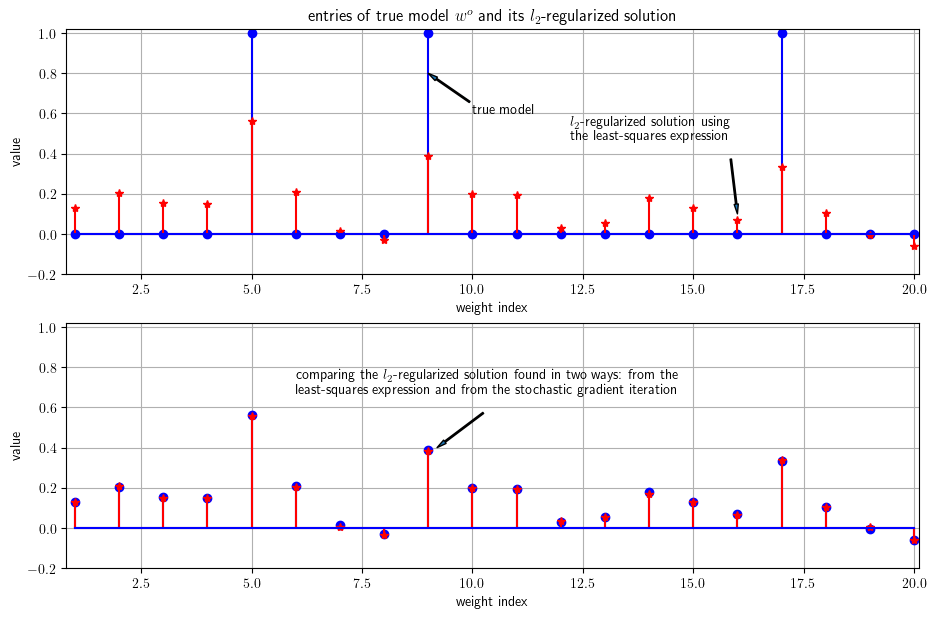

In [5]:
# figure 4 (comparing least-squares and iterative solution)

f, axs =  plt.subplots(2, 1, figsize=(11,7))

x = np.arange(1,M+1,1) 
axs[0].stem(x, wo, 'b', markerfmt='bo')
axs[0].stem(x, w_star_2, linefmt='r', markerfmt='*r', basefmt='b')
axs[0].set_ylabel(r'value')
axs[0].set_xlabel(r'weight index')
axs[0].grid()
axs[0].set_xlim([0.8, 20.1])
axs[0].set_ylim([-0.2, 1.02])
axs[0].set_title(r'entries of true model $w^o$ and its $l_2$-regularized solution')
axs[0].annotate('true model',xy=(9.,0.8),xytext=(10,0.6),arrowprops={"width":1,"headwidth":3,'headlength':7});
axs[0].annotate(r"""
$l_2$-regularized solution using 
the least-squares expression
"""
,xy=(16,0.1),xytext=(12.2,0.4),arrowprops={"width":1,"headwidth":3,'headlength':7});

axs[1].stem(x, w_star_2, 'b', markerfmt='bo')
axs[1].stem(x, w_star_2_recursive, linefmt='r', markerfmt='*r', basefmt='b')
axs[1].set_ylabel(r'value')
axs[1].set_xlabel(r'weight index')
axs[1].grid()
axs[1].set_xlim([0.8, 20.1])
axs[1].set_ylim([-0.2, 1.02])
axs[1].annotate(r"""
                comparing the $l_2$-regularized solution found in two ways: from the 
                least-squares expression and from the stochastic gradient iteration
                """
              ,xy=(9.2,0.4),xytext=(6,0.6),arrowprops={"width":1,"headwidth":3,'headlength':7});


#plt.savefig('fig 51.4.pdf')

**Figure 51.4** The top plot shows the true model $w^{o}$ with three nonzero entries at value 1 while all other entries are at $0$. The top plot also shows the $\ell_2-$regularized solution, $w^{\star}_{reg}$, that is obtained by using the least-squares expression (51.21). The bottom plot compares the solutions that are obtained from the least-squares expression (51.21) and from the stochastic  recursion (51.64) using $20$ runs over the data,  $\alpha=0$, and $\mu=0.0001$. It is seen that recursion (51.64) is able to learn the $\ell_2-$regularized solution well.


We use the stochastic construction (51.64) to illustrate the behavior of the different regularization modes, by considering the following numerical example. We generate $N=4000$ random data points $\{x(n),y_n\}$ related through the linear model:

$$
x(n)=y_n^{\sf T} w^o +v(n) \tag{51.65}
$$

where $v(n)$ is white Gaussian noise with variance $\sigma_v^2=0.01$, and each observation vector has dimension $M=20$. We generate a sparse true model $w^o$ consisting of three randomly chosen entries set to 1, while all other entries of $w^o$ are set to $0$. Figures 51.4 and 51.5 illustrate the results that follow from using $20$ runs over the data with $\mu=0.0001$, $\alpha=5,$ and $\rho=2$. It is seen in the lower plot from Fig. 51.4 that the stochastic recursion (51.64) converges to a good approximation for the actual least-squares solution from (51.21). The middle plot of Fig. 51.5 illustrates the sparsity property of the $\ell_1-$ regularized solution.

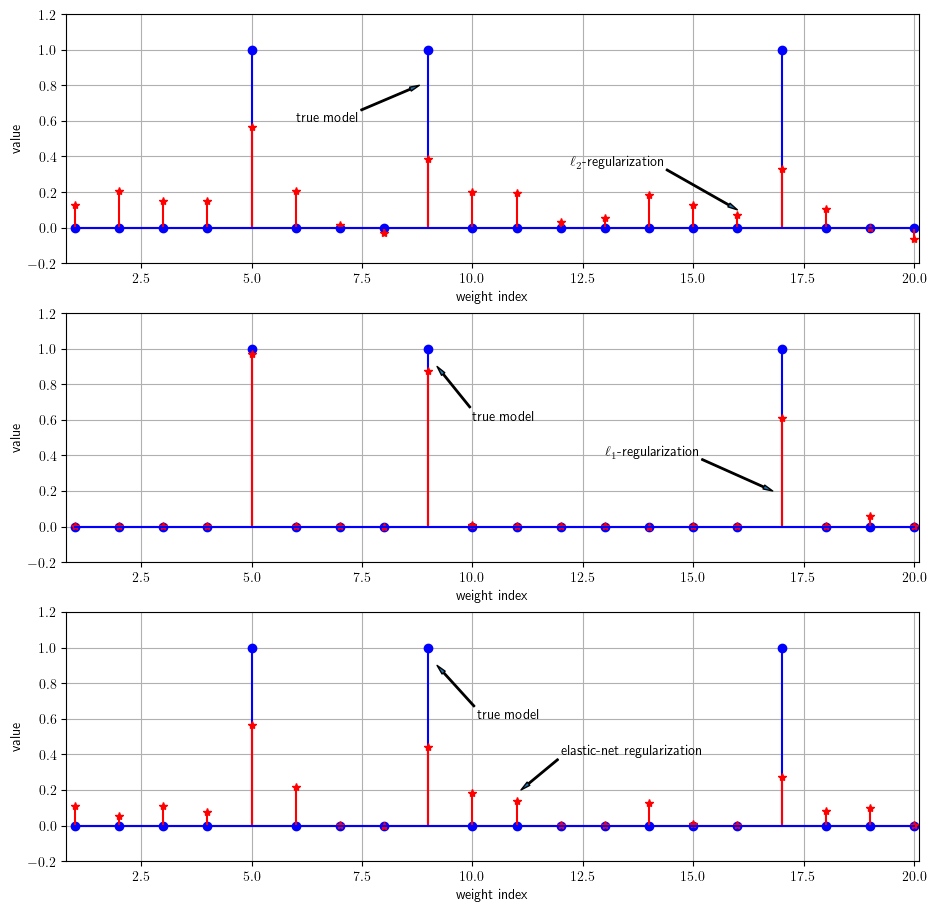

In [7]:
# figure 5 (comparing l_2, l_1, and elastic-net regularization)

f, axs =  plt.subplots(3, 1, figsize=(11,11))

x = np.arange(1,M+1,1) 
axs[0].stem(x, wo, 'b', markerfmt='bo')
axs[0].stem(x, w_star_2, linefmt='r', markerfmt='*r', basefmt='b')
axs[0].set_ylabel(r'value')
axs[0].set_xlabel(r'weight index')
axs[0].grid()
axs[0].set_xlim([0.8, 20.1])
axs[0].set_ylim([-0.2, 1.2])
axs[0].annotate(r'true model',xy=(8.8,0.8),xytext=(6,0.6),arrowprops={"width":1,"headwidth":3,'headlength':7});
axs[0].annotate(r'$\ell_2$-regularization',xy=(16,0.1),xytext=(12.2,0.35),arrowprops={"width":1,"headwidth":3,'headlength':7});

axs[1].stem(x, wo, 'b', markerfmt='bo')
axs[1].stem(x, w_star_1, linefmt='r', markerfmt='*r', basefmt='b')
axs[1].set_ylabel(r'value')
axs[1].set_xlabel(r'weight index')
axs[1].grid()
axs[1].set_xlim([0.8, 20.1])
axs[1].set_ylim([-0.2, 1.2])
axs[1].annotate('true model',xy=(9.2,0.9),xytext=(10,0.6),arrowprops={"width":1,"headwidth":3,'headlength':7});
axs[1].annotate(r'$\ell_1$-regularization',xy=(16.8,0.2),xytext=(13,0.4),arrowprops={"width":1,"headwidth":3,'headlength':7});

axs[2].stem(x, wo, 'b', markerfmt='bo')
axs[2].stem(x, w_star_elastic, linefmt='r', markerfmt='*r', basefmt='b')
axs[2].set_ylabel(r'value')
axs[2].set_xlabel(r'weight index')
axs[2].grid()
axs[2].set_xlim([0.8, 20.1])
axs[2].set_ylim([-0.2, 1.2])
axs[2].annotate(r'true model',xy=(9.2,0.9),xytext=(10.1,0.6),arrowprops={"width":1,"headwidth":3,'headlength':7});
axs[2].annotate(r'elastic-net regularization',xy=(11.1,0.2),xytext=(12,0.4),arrowprops={"width":1,"headwidth":3,'headlength':7});

#plt.savefig('fig 51.5.pdf')

**Figure 51.5** All three plots show the true model $w^{o}$ with three nonzero entries at value 1 while all other entries are at $0$. In each case, the true model is compared against the $\ell_2-$ regularized solution (top plot), the $\ell_1-$ regularized solution using $\alpha=5$ (middle plot), and the elastic-net regularized solution using $\alpha=5$ and $\rho=2$ (bottom plot). All these regularized solutions are obtained by using the stochastic (sub)gradient recursion (51.64) using $20$ runs over the data and $\mu=0.0001$. The middle plot illustrates  how $\ell_1-$regularization leads to a sparse solution, while the elastic-net regularized solution has slightly more non-zero entries.


## Soft-thresholding functions

In [8]:
#soft thresholding functions

alpha = 1
T = []
i = np.arange(-3, 3.1, 0.1)
for x in i:
    if x >= alpha:
        T.append(x-alpha)
    else:
        if x<=-alpha:
            T.append(x+alpha)
        else:
            if -alpha < x and x < alpha:
                T.append(0)
               
            
N = max(np.array(T).shape)
T = np.array(T)    
S = -0.5 * np.power(T, 2) - alpha * abs(T) + np.multiply(i, T)


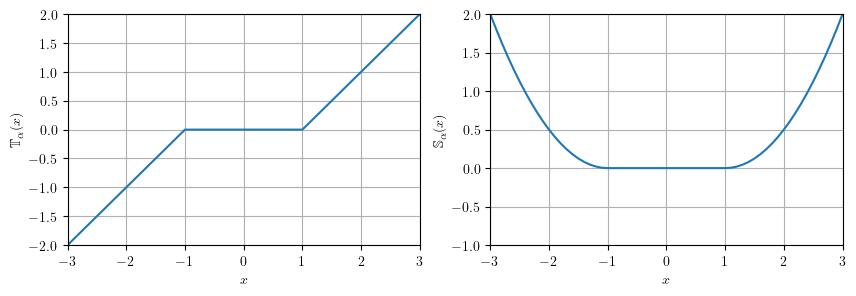

In [10]:
# figure 6 (threshold functions)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "text.latex.preamble": r"\usepackage{amsfonts}"
})

f, axs =  plt.subplots(1, 2, figsize=(10,3))
axs[0].plot(i, T)
axs[0].set_ylabel(r'$\mathbb{T}_\alpha(x)$')
axs[0].set_xlabel('$x$')
axs[0].grid()
axs[0].set_xlim([-3, 3])
axs[0].set_ylim([-2, 2])

axs[1].plot(i, S)
axs[1].set_ylabel(r'$\mathbb{S}_\alpha(x)$')
axs[1].set_xlabel('$x$')
axs[1].grid()
axs[1].set_xlim([-3, 3])
axs[1].set_ylim([-1, 2]);

#plt.savefig('fig 51.6.pdf')

**Figure 51.6** Plots of the soft-thresholding functions $T_\alpha(x)$ and $S_\alpha(x)$ for $\alpha = 1$.